In [ ]:
!pip install medmnist grad-cam

import medmnist
from medmnist import INFO, Evaluator
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
from torchvision import models
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from pytorch_grad_cam.metrics.road import ROADCombined
import numpy as np
import cv2
from PIL import Image

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=078b4a4fab1386fb202d55d3f78168eacd692ef08c03f9712533bbd9d1853bae
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=7882d76a8cb5d76de2ebba6b96e08b2663a7509397320da1c8ae2e0a1304558a
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built grad-cam fire
DEVICE: cuda:0


In [2]:
# parser to check for reasonable datasets
def medmnist_info_parser(task=""):
    results = list()
    print("MedMNIST Info")

    for key in INFO.keys():
        info = INFO[key]
        if task in info["task"]:
            results.append(info["python_class"])
            print(info["python_class"], info["task"], f"{len(info['label'])} classes", sep="; ")
    print()

    return results

# dummy check for model
def dummy_test(model):
    input_data = torch.randn(1, 3, 224, 224)
    with torch.no_grad():
        model = model.eval()
        pred = model(input_data).numpy().squeeze()
        pred_bin = np.where(pred-pred.max()==0, 1, 0)
        print("Dummy test")
        print(*[f"{b} | {p:.2f} "for (p, b) in zip(pred, pred_bin)], sep="\n")
        print()

In [3]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

### YOUR CODE BELOW ###
def prep_data_and_model(data_flag, model_name, batch_size=64, pretrained=True, freeze=True, trainable_layers=2):
    # dataset
    info = INFO[data_flag]
    num_classes = len(info["label"])
    DataClass = getattr(medmnist, info['python_class'])

    # splits
    train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
    valid_set = DataClass(split='val', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
    test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)

    # dataloaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    image_shape = next(iter(train_loader))[0][0].cpu().numpy().shape
    print(f"Image shape: {image_shape}")

    # model
    if pretrained:
        weights = "DEFAULT"
    if not pretrained:
        weights = None
    # load model
    model = getattr(models, model_name)(weights=weights)
    module_names = [name for name, module in model.named_children()]
    layer_names = [name for name in module_names if "layer" in name]
    if freeze:
        trainable_layer_names = list()
        # freeze layers
        for param in model.parameters():
            param.requires_grad = False
        # unfreeze layers
        for param in model.fc.parameters():
            param.requires_grad = True
        for i, layer_name in enumerate(layer_names):
            if i + 1 > len(layer_names) - trainable_layers:
                trainable_layer_names.append(layer_name)
                for param in getattr(model, layer_name).parameters():
                    param.requires_grad = True
        print(f"Trainable layers: {', '.join(trainable_layer_names)}")

    # replace fc layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.fc.reset_parameters()
    print(f"Modules of {model_name}:", " > ".join(module_names))
    print()

    return train_loader, valid_loader, test_loader, model

data_flag_list = medmnist_info_parser()
DATA_FLAG = "dermamnist"
MODEL_NAME = "resnet50"
BATCH_SIZE = 128
PRETRAINED = True
FREEZE = True

train_loader, valid_loader, test_loader, model = prep_data_and_model(DATA_FLAG, MODEL_NAME, BATCH_SIZE, PRETRAINED, FREEZE)
dummy_test(model)

MedMNIST Info
PathMNIST; multi-class; 9 classes
ChestMNIST; multi-label, binary-class; 14 classes
DermaMNIST; multi-class; 7 classes
OCTMNIST; multi-class; 4 classes
PneumoniaMNIST; binary-class; 2 classes
RetinaMNIST; ordinal-regression; 5 classes
BreastMNIST; binary-class; 2 classes
BloodMNIST; multi-class; 8 classes
TissueMNIST; multi-class; 8 classes
OrganAMNIST; multi-class; 11 classes
OrganCMNIST; multi-class; 11 classes
OrganSMNIST; multi-class; 11 classes
OrganMNIST3D; multi-class; 11 classes
NoduleMNIST3D; binary-class; 2 classes
AdrenalMNIST3D; binary-class; 2 classes
FractureMNIST3D; multi-class; 3 classes
VesselMNIST3D; binary-class; 2 classes
SynapseMNIST3D; binary-class; 2 classes



100%|██████████| 19725078/19725078 [00:02<00:00, 8576022.37it/s] 


Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Image shape: (3, 28, 28)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.6MB/s]


Trainable layers: layer3, layer4
Modules of resnet50: conv1 > bn1 > relu > maxpool > layer1 > layer2 > layer3 > layer4 > avgpool > fc

Dummy test
0 | -0.23 
0 | -0.15 
0 | -0.15 
1 | 0.09 
0 | -0.14 
0 | -0.04 
0 | -0.15 



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 20.40it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 66.27it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


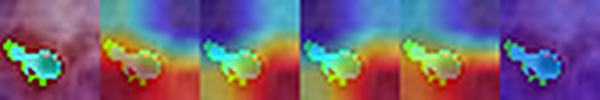

Train Epoch: 01 | Loss: 1.958948 | Validation loss: 1.922381 | Acc: 14.757177



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 14.62it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 59.91it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


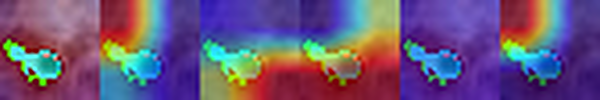

Train Epoch: 02 | Loss: 1.499406 | Validation loss: 1.119719 | Acc: 53.283343



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 77.48it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


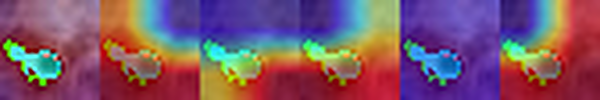

Train Epoch: 03 | Loss: 0.895953 | Validation loss: 1.055137 | Acc: 68.762560



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 24.59it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 102.03it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


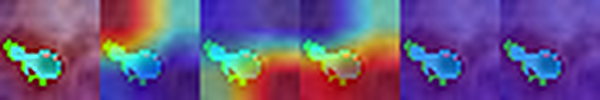

Train Epoch: 04 | Loss: 0.679503 | Validation loss: 1.049747 | Acc: 74.105263



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 23.92it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 98.62it/s] 

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


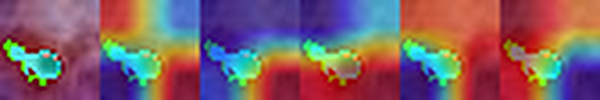

Train Epoch: 05 | Loss: 0.533846 | Validation loss: 1.060264 | Acc: 79.604815



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 19.99it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 78.43it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


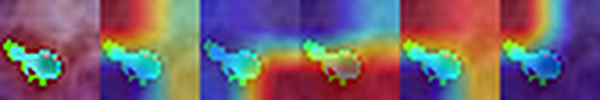

Train Epoch: 06 | Loss: 0.422656 | Validation loss: 1.090795 | Acc: 85.106908



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 24.52it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 100.23it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


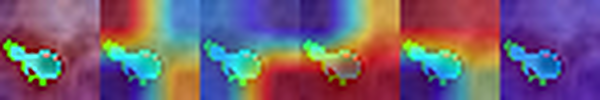

Train Epoch: 07 | Loss: 0.338444 | Validation loss: 1.128596 | Acc: 89.790670



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 24.99it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 97.81it/s] 

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


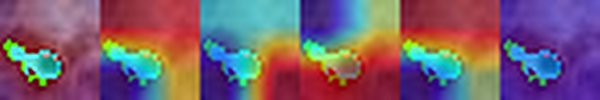

Train Epoch: 08 | Loss: 0.273058 | Validation loss: 1.170210 | Acc: 92.992225



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 23.98it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 73.49it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


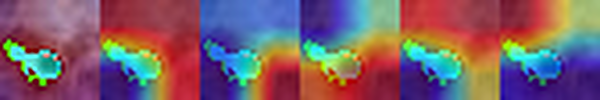

Train Epoch: 09 | Loss: 0.208283 | Validation loss: 1.221409 | Acc: 95.383523



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 23.37it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 94.38it/s] 

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


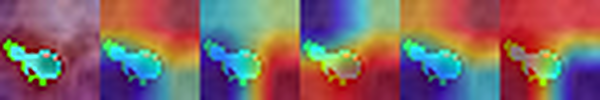

Train Epoch: 10 | Loss: 0.163113 | Validation loss: 1.277865 | Acc: 96.775568



In [4]:
# You are expected to save the models during training
# It is up to you to decide when and how to do so, but this is likely to influence the explanation results

### YOUR CODE BELOW ###

def benchmark(data_loader, model, data_index=None, size_threshold=100):
    print(f"Grad-cam testing")

    model = model.to(device)

    input_tensor, targets = next(iter(train_loader))

    if data_index is None:
        data_index = np.random.randint(len(input_tensor)-1)

    input_tensor = input_tensor.to(device)[data_index]
    targets = targets[data_index].cpu().numpy()
    image = np.uint8(255 * input_tensor.cpu().numpy().transpose((1, 2, 0)))

    layer_names = [name for name, module in model.named_children() if "layer" in name]
    target_layers = [getattr(model, layer_names[-2])]

    methods = [ ("GradCAM", GradCAM(model=model, target_layers=target_layers)),
                ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
                ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
                ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
                ("RandomCAM", RandomCAM(model=model, target_layers=target_layers)) ]

    images = [image]
    method_names = list()

    for name, method in methods:
        method_names.append(name)
        with method as cam_method:
            cam = cam_method(input_tensor=input_tensor.unsqueeze(0), targets=[ClassifierOutputTarget(targets)])
            cam_on_image = show_cam_on_image(np.float32(image/255), cam[0, :], use_rgb=True)

        cam = np.uint8(255 * cam[0, :])
        cam = cv2.merge([cam, cam, cam])
        images.append(cam_on_image)

    images = np.hstack(images)

    if len(image) < size_threshold:
        new_shape = (size_threshold * (len(methods) + 1), size_threshold)
        images = cv2.resize(images, new_shape, interpolation=4)

    return Image.fromarray(images), method_names, data_index

def train(device, model, train_loader, epochs, learning_rate):
    model.to(device)

    # some custom stuff
    saved_models = dict()
    data_index = None

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        losses = []
        valid_losses = []
        accuracies = []

        for i, (data, target) in enumerate(tqdm(train_loader, desc='Training-loop')):

            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            preds = torch.argmax(output.detach().cpu(), axis=1)
            labels = target.detach().cpu()
            acc = np.mean(preds.numpy() == labels.numpy())
            losses.append(loss.item())
            accuracies.append(acc)

            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for idx, (data, target) in enumerate(tqdm(valid_loader, desc='Validation-loop')):
                optimizer.zero_grad()
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred, target)
                valid_losses.append(loss.item())

        # We suggest you modify this code to run the continuous explanations
        images, cam_method_names, data_index = benchmark(train_loader, model, data_index)
        print("Raw, " + ", ".join(cam_method_names))
        display(images)
        saved_models[epoch] = model
        print(\
            f"Train Epoch: {epoch + 1:02d} | " +
            f"Loss: {np.mean(losses):.6f} | " +
            f"Validation loss: {np.mean(valid_losses):.6f} | " +
            f"Acc: {np.mean(accuracies) * 100:.6f}"
        )
        print()

    return model

EPOCHS = 10
LR = 1e-5
model_trained = train(device, model, train_loader, EPOCHS, LR)

In [5]:
def test(device, model, data_loader, mean=0.5432, std=0.2731):
    model.eval()
    preds = []
    pred_list = []

    with torch.no_grad():
        for index, (image, target) in enumerate(tqdm(data_loader, desc='Test-loop')):
            images = images.to(device)
            target = target

            output = model(images).detach().cpu()
            preds = np.argmax(output, axis=1).numpy()
            labels = target.numpy()

            correct += (preds == labels).sum()

            pred_list.append(preds)

    acc = correct / len(test_loader.dataset) * 100
    print(f"Test Accuracy: {acc:.6f}")

    # You should modify this section to reflect your CAM evaluation
    # ...

    return np.concatenate(pred_list)

Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 27.30it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 96.72it/s] 

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


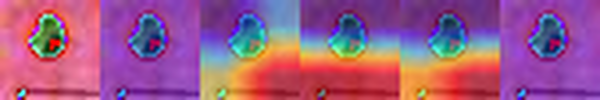

Train Epoch: 01 | Loss: 10.829554 | Validation loss: 8.484650 | Acc: 0.360048



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 25.44it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 104.64it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


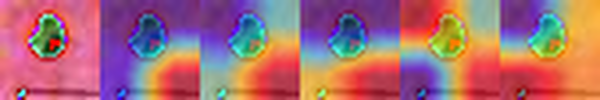

Train Epoch: 02 | Loss: 2.509404 | Validation loss: 1.434182 | Acc: 52.683612



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 20.19it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 76.54it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


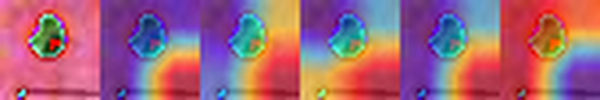

Train Epoch: 03 | Loss: 1.096760 | Validation loss: 1.118101 | Acc: 67.973834



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 25.00it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 97.81it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


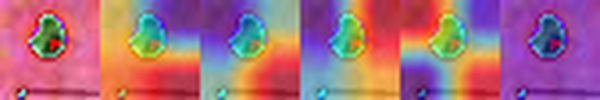

Train Epoch: 04 | Loss: 0.745542 | Validation loss: 1.046234 | Acc: 75.043959



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 24.11it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 99.93it/s] 

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


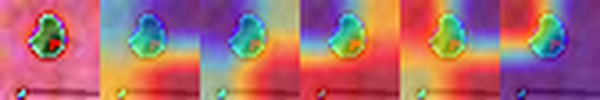

Train Epoch: 05 | Loss: 0.531093 | Validation loss: 1.042721 | Acc: 82.435855



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 23.69it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 102.64it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


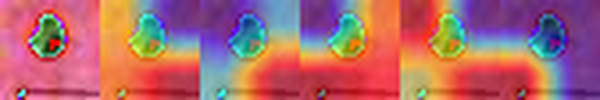

Train Epoch: 06 | Loss: 0.381671 | Validation loss: 1.063295 | Acc: 88.260915



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 23.45it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 97.93it/s] 

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


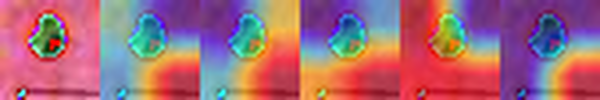

Train Epoch: 07 | Loss: 0.274315 | Validation loss: 1.098568 | Acc: 92.830443



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 19.08it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 74.41it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


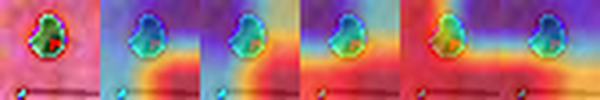

Train Epoch: 08 | Loss: 0.197956 | Validation loss: 1.144316 | Acc: 95.368720



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 24.27it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 96.33it/s] 

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


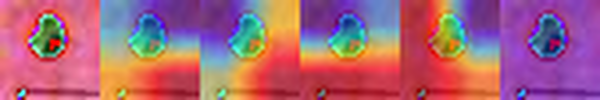

Train Epoch: 09 | Loss: 0.140807 | Validation loss: 1.187042 | Acc: 97.102273



Validation-loop: 100%|██████████| 8/8 [00:00<00:00, 23.83it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 91.48it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


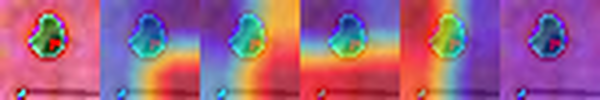

Train Epoch: 10 | Loss: 0.100145 | Validation loss: 1.234829 | Acc: 98.281250



In [7]:
#Analysing feature selection

EPOCHS = 10
LR = 1e-5
model_trained = train(device, model, train_loader, EPOCHS, LR)